# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

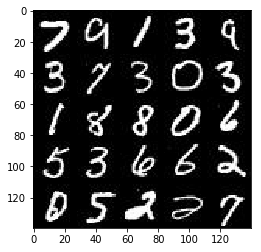

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

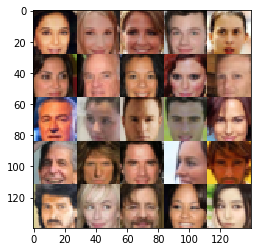

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def lrelu(x, alpha = 0.2, name='lrelu'):
    #with tf.variable_scope(name):
    f1 = 0.5*(1+alpha)
    f2 = 0.5*(1-alpha)
    return f1*x + f2*abs(x)

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    rate = 0.1
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28*28*3 -> 14*14*64
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same', 
                              # kernel_initializer = tf.random_normal_initializer(stddev=0.02))
                              kernel_initializer = tf.contrib.layers.xavier_initializer())
        # x1 = tf.maximum(0.2*x1, x1)
        x1 = lrelu(x1)
        # add drop out layer 
        x1 = tf.layers.dropout(x1, rate) 
        
        # 14*14*64 -> 7*7*128
        x2 = tf.layers.conv2d(x1, 128, 5, strides =2 , padding='same',
                              kernel_initializer = tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=True)
        # x2 = tf.maximum(0.2*x2, x2)
        x2 = lrelu(x2)
        x2 = tf.layers.dropout(x2, rate)
        
        # 7*7*128 -> 3*3*256
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same', 
                              kernel_initializer = tf.contrib.layers.xavier_initializer())
        x3 = tf.layers.batch_normalization(x3, training=True)
        # x3 = tf.maximum(0.2*x3, x3)
        x3 = lrelu(x3)
        x3 = tf.layers.dropout(x3, rate)
        
        # flatten 
        # s = x3.get_shape().as_list()
        # flat = tf.reshape(x3, (-1, s[1]*s[2]*s[3]))
        flat = tf.contrib.layers.flatten(x3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = True
    if is_train == True:
        reuse = False
    rate = 0.1
    with tf.variable_scope('generator', reuse=reuse):
        # z_dim -> 7*7*256
        # x = tf.layers.dense(z, 7*7*256)
        # x = tf.reshape(x, (-1, 7, 7, 256))
        x = tf.layers.dense(z, 2*2*512)
        x = tf.reshape(x, (-1, 2, 2, 512))
        
        # 7*7*256 -> 14*14*128
        # x2 = tf.layers.conv2d_transpose(x, 128, 5, strides=2, padding='same', 
        #                                kernel_initializer = tf.contrib.layers.xavier_initializer())
        # 7 * 7 * 256
        x2 = tf.layers.conv2d_transpose(x, 256, 5, strides=2, padding='valid', 
                                       kernel_initializer = tf.contrib.layers.xavier_initializer())
        s = x2.get_shape().as_list()
        # print('x2.shape {}'.format(s))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        # x2 = tf.maximum(0.2*x2, x2)
        x2 = lrelu(x2)
        x2 = tf.layers.dropout(x2, rate, training=is_train)
        
        # 14*14*128 -> 28*28*64
        # x3 = tf.layers.conv2d_transpose(x2, 64, 5, strides=2, padding='same', 
        #                               kernel_initializer = tf.contrib.layers.xavier_initializer())
        # 14 * 14 * 128
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same',
                                       kernel_initializer = tf.contrib.layers.xavier_initializer())
        s = x3.get_shape().as_list()
        # print('x3.shape {}'.format(s))
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        # x3 = tf.maximum(0.2*x3, x3)
        x3 = lrelu(x3)
        x3 = tf.layers.dropout(x3, rate, training=is_train)
        
        # 28*28*64 -> 28*28*3
        # logits = tf.layers.conv2d(x3, out_channel_dim, 5, strides=1, padding='same', 
        #                         kernel_initializer = tf.contrib.layers.xavier_initializer())
        # 28 * 28 * 3
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same', 
                                 kernel_initializer = tf.contrib.layers.xavier_initializer())
        s = logits.get_shape().as_list()
        # print('logits.shape {}'.format(s))
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
import numpy as np
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
    
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        # tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*np.random.uniform(0.7, 1.2)))
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1.-smooth)))

    d_loss_fake = tf.reduce_mean(
 #       tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)*np.random.uniform(0.0, 0.3)))
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)*(1.-smooth)))

    g_loss = tf.reduce_mean(
        # tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)*np.random.uniform(0.8, 1.0)))
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)*(1.-smooth)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    vts = tf.trainable_variables()
    d_v = [v for v in vts if v.name.startswith('discriminator')]
    g_v = [v for v in vts if v.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list = d_v)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list = g_v)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    # x = ((x - x.min())/(255 - x.min()))
    x = ((x - x.min())/(x.max() - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
        # TODO: Build Model
    tf.reset_default_graph()
    (_, image_width, image_height, image_channels) = data_shape
    
    input_real, input_z, l_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, l_rate, beta1)
    
    samples, losses = [], []
    steps = 0
    print_every = 3
    show_every = epoch_count*30
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # scale input images 
                # scale_images = scale(batch_images)
                batch_images *= 2.0 
                scale_images = batch_images
                # Run optimizer 
                _= sess.run(d_opt, feed_dict={input_z: batch_z, input_real: scale_images, l_rate: learning_rate})
                _= sess.run(g_opt, feed_dict={input_z: batch_z, input_real: scale_images, l_rate: learning_rate})

                if steps % print_every == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real:scale_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))
                if steps % show_every == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.7192... Generator Loss: 1.7600
Epoch 1/2... Discriminator Loss: 0.4397... Generator Loss: 2.6019
Epoch 1/2... Discriminator Loss: 0.5151... Generator Loss: 2.7455
Epoch 1/2... Discriminator Loss: 0.7093... Generator Loss: 2.0504
Epoch 1/2... Discriminator Loss: 1.7644... Generator Loss: 0.5465
Epoch 1/2... Discriminator Loss: 1.9256... Generator Loss: 0.4948
Epoch 1/2... Discriminator Loss: 0.7144... Generator Loss: 2.6240
Epoch 1/2... Discriminator Loss: 1.1406... Generator Loss: 3.5466
Epoch 1/2... Discriminator Loss: 2.5119... Generator Loss: 0.4347
Epoch 1/2... Discriminator Loss: 0.8748... Generator Loss: 1.7247
Epoch 1/2... Discriminator Loss: 1.6663... Generator Loss: 0.6253
Epoch 1/2... Discriminator Loss: 1.1875... Generator Loss: 3.9416
Epoch 1/2... Discriminator Loss: 0.7228... Generator Loss: 2.1307
Epoch 1/2... Discriminator Loss: 1.1552... Generator Loss: 1.0369
Epoch 1/2... Discriminator Loss: 1.5505... Generator Loss: 3.1207
Epoch 1/2.

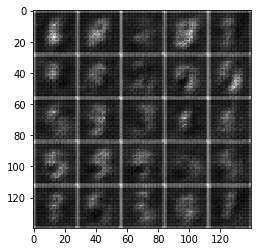

Epoch 1/2... Discriminator Loss: 0.9322... Generator Loss: 1.1770
Epoch 1/2... Discriminator Loss: 0.8418... Generator Loss: 1.2648
Epoch 1/2... Discriminator Loss: 1.4664... Generator Loss: 0.5547
Epoch 1/2... Discriminator Loss: 1.1130... Generator Loss: 1.8898
Epoch 1/2... Discriminator Loss: 1.0589... Generator Loss: 0.9262
Epoch 1/2... Discriminator Loss: 1.4333... Generator Loss: 2.4123
Epoch 1/2... Discriminator Loss: 0.9773... Generator Loss: 0.9574
Epoch 1/2... Discriminator Loss: 0.8778... Generator Loss: 1.0752
Epoch 1/2... Discriminator Loss: 0.9543... Generator Loss: 1.4175
Epoch 1/2... Discriminator Loss: 0.9781... Generator Loss: 0.9805
Epoch 1/2... Discriminator Loss: 1.4941... Generator Loss: 2.7198
Epoch 1/2... Discriminator Loss: 0.9199... Generator Loss: 1.1237
Epoch 1/2... Discriminator Loss: 0.8843... Generator Loss: 1.0324
Epoch 1/2... Discriminator Loss: 1.3568... Generator Loss: 2.4047
Epoch 1/2... Discriminator Loss: 1.1361... Generator Loss: 0.7951
Epoch 1/2.

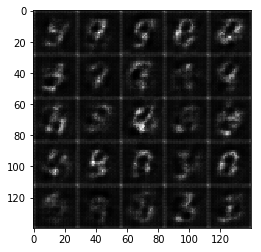

Epoch 1/2... Discriminator Loss: 1.1370... Generator Loss: 0.7662
Epoch 1/2... Discriminator Loss: 0.8573... Generator Loss: 1.1273
Epoch 1/2... Discriminator Loss: 1.0717... Generator Loss: 1.9431
Epoch 1/2... Discriminator Loss: 1.1119... Generator Loss: 0.7181
Epoch 1/2... Discriminator Loss: 1.0402... Generator Loss: 1.4220
Epoch 1/2... Discriminator Loss: 1.4018... Generator Loss: 0.5753
Epoch 1/2... Discriminator Loss: 0.8864... Generator Loss: 1.0453
Epoch 1/2... Discriminator Loss: 1.0514... Generator Loss: 1.8289
Epoch 1/2... Discriminator Loss: 1.0503... Generator Loss: 0.7613
Epoch 1/2... Discriminator Loss: 0.7699... Generator Loss: 1.3725
Epoch 1/2... Discriminator Loss: 0.9000... Generator Loss: 0.9844
Epoch 1/2... Discriminator Loss: 1.2029... Generator Loss: 2.2008
Epoch 1/2... Discriminator Loss: 1.1634... Generator Loss: 0.7248
Epoch 1/2... Discriminator Loss: 1.0720... Generator Loss: 1.9232
Epoch 1/2... Discriminator Loss: 0.9920... Generator Loss: 0.8380
Epoch 1/2.

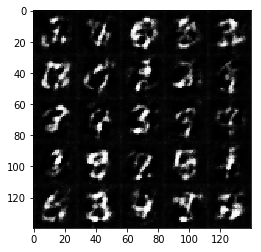

Epoch 1/2... Discriminator Loss: 0.7881... Generator Loss: 1.2841
Epoch 1/2... Discriminator Loss: 0.7307... Generator Loss: 2.1078
Epoch 1/2... Discriminator Loss: 0.8416... Generator Loss: 1.0042
Epoch 1/2... Discriminator Loss: 0.6615... Generator Loss: 1.6939
Epoch 1/2... Discriminator Loss: 0.8867... Generator Loss: 0.9575
Epoch 1/2... Discriminator Loss: 1.2196... Generator Loss: 3.0600
Epoch 1/2... Discriminator Loss: 0.8199... Generator Loss: 1.1398
Epoch 1/2... Discriminator Loss: 0.7118... Generator Loss: 1.3199
Epoch 1/2... Discriminator Loss: 0.7804... Generator Loss: 1.6536
Epoch 1/2... Discriminator Loss: 0.7320... Generator Loss: 1.1992
Epoch 1/2... Discriminator Loss: 0.8084... Generator Loss: 2.2267
Epoch 1/2... Discriminator Loss: 0.7807... Generator Loss: 1.1365
Epoch 1/2... Discriminator Loss: 1.1274... Generator Loss: 0.6857
Epoch 1/2... Discriminator Loss: 1.2542... Generator Loss: 3.0240
Epoch 1/2... Discriminator Loss: 0.7824... Generator Loss: 1.1210
Epoch 1/2.

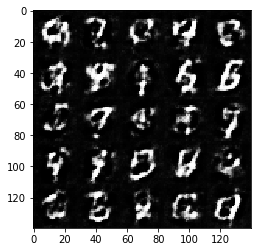

Epoch 1/2... Discriminator Loss: 0.7898... Generator Loss: 1.1180
Epoch 1/2... Discriminator Loss: 0.8380... Generator Loss: 2.2511
Epoch 1/2... Discriminator Loss: 0.7252... Generator Loss: 1.2225
Epoch 1/2... Discriminator Loss: 0.7655... Generator Loss: 1.6253
Epoch 1/2... Discriminator Loss: 0.7501... Generator Loss: 1.1268
Epoch 1/2... Discriminator Loss: 0.8325... Generator Loss: 1.8822
Epoch 1/2... Discriminator Loss: 0.9187... Generator Loss: 0.9147
Epoch 1/2... Discriminator Loss: 0.7900... Generator Loss: 1.3290
Epoch 1/2... Discriminator Loss: 0.8937... Generator Loss: 0.9194
Epoch 1/2... Discriminator Loss: 0.9910... Generator Loss: 2.8296
Epoch 1/2... Discriminator Loss: 1.1341... Generator Loss: 0.7260
Epoch 1/2... Discriminator Loss: 0.8243... Generator Loss: 1.5868
Epoch 1/2... Discriminator Loss: 0.9048... Generator Loss: 1.9442
Epoch 1/2... Discriminator Loss: 0.8994... Generator Loss: 1.0771
Epoch 1/2... Discriminator Loss: 0.8993... Generator Loss: 1.0156
Epoch 1/2.

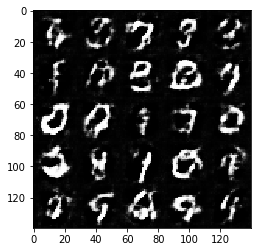

Epoch 1/2... Discriminator Loss: 0.9325... Generator Loss: 2.6356
Epoch 1/2... Discriminator Loss: 0.7212... Generator Loss: 1.6835
Epoch 1/2... Discriminator Loss: 1.1302... Generator Loss: 0.7713
Epoch 1/2... Discriminator Loss: 0.7177... Generator Loss: 1.8775
Epoch 1/2... Discriminator Loss: 1.0950... Generator Loss: 0.7329
Epoch 1/2... Discriminator Loss: 1.7865... Generator Loss: 3.2247
Epoch 1/2... Discriminator Loss: 0.7685... Generator Loss: 1.5440
Epoch 1/2... Discriminator Loss: 0.8391... Generator Loss: 1.0678
Epoch 1/2... Discriminator Loss: 1.0099... Generator Loss: 0.7962
Epoch 1/2... Discriminator Loss: 0.7582... Generator Loss: 1.4134
Epoch 1/2... Discriminator Loss: 0.8397... Generator Loss: 1.1334
Epoch 1/2... Discriminator Loss: 0.9957... Generator Loss: 2.2520
Epoch 1/2... Discriminator Loss: 0.9375... Generator Loss: 0.9870
Epoch 1/2... Discriminator Loss: 0.8777... Generator Loss: 0.9817
Epoch 1/2... Discriminator Loss: 0.7880... Generator Loss: 2.1439
Epoch 1/2.

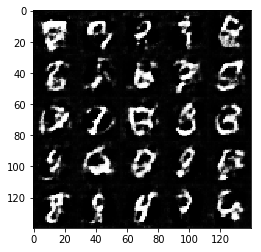

Epoch 1/2... Discriminator Loss: 0.9406... Generator Loss: 0.8442
Epoch 1/2... Discriminator Loss: 1.0235... Generator Loss: 2.0499
Epoch 1/2... Discriminator Loss: 0.8843... Generator Loss: 0.9535
Epoch 1/2... Discriminator Loss: 1.2217... Generator Loss: 2.6808
Epoch 1/2... Discriminator Loss: 0.7481... Generator Loss: 1.2709
Epoch 1/2... Discriminator Loss: 0.9558... Generator Loss: 0.8948
Epoch 1/2... Discriminator Loss: 1.0596... Generator Loss: 0.7425
Epoch 1/2... Discriminator Loss: 0.9996... Generator Loss: 2.3304
Epoch 1/2... Discriminator Loss: 0.7121... Generator Loss: 1.5834
Epoch 1/2... Discriminator Loss: 0.7852... Generator Loss: 1.1713
Epoch 1/2... Discriminator Loss: 0.7281... Generator Loss: 1.3443
Epoch 1/2... Discriminator Loss: 0.7907... Generator Loss: 1.5584
Epoch 1/2... Discriminator Loss: 0.7541... Generator Loss: 1.1950
Epoch 1/2... Discriminator Loss: 1.1094... Generator Loss: 0.7104
Epoch 1/2... Discriminator Loss: 1.2873... Generator Loss: 2.8813
Epoch 1/2.

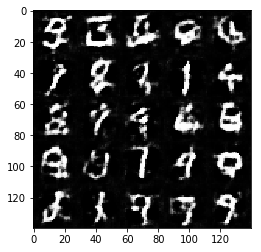

Epoch 1/2... Discriminator Loss: 0.7540... Generator Loss: 1.3226
Epoch 1/2... Discriminator Loss: 0.7161... Generator Loss: 1.3970
Epoch 1/2... Discriminator Loss: 1.1525... Generator Loss: 0.7868
Epoch 1/2... Discriminator Loss: 0.6811... Generator Loss: 1.5592
Epoch 1/2... Discriminator Loss: 1.0711... Generator Loss: 0.7210
Epoch 1/2... Discriminator Loss: 0.9845... Generator Loss: 2.4105
Epoch 1/2... Discriminator Loss: 1.3641... Generator Loss: 0.5900
Epoch 1/2... Discriminator Loss: 0.8102... Generator Loss: 1.3927
Epoch 1/2... Discriminator Loss: 0.7436... Generator Loss: 1.2799
Epoch 1/2... Discriminator Loss: 0.9825... Generator Loss: 0.8806
Epoch 1/2... Discriminator Loss: 0.7993... Generator Loss: 1.9480
Epoch 1/2... Discriminator Loss: 0.9163... Generator Loss: 0.9887
Epoch 1/2... Discriminator Loss: 0.7883... Generator Loss: 1.5955
Epoch 1/2... Discriminator Loss: 0.7500... Generator Loss: 1.4224
Epoch 1/2... Discriminator Loss: 1.2950... Generator Loss: 0.6412
Epoch 1/2.

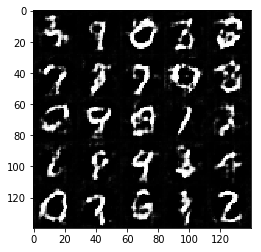

Epoch 1/2... Discriminator Loss: 1.2304... Generator Loss: 2.6887
Epoch 1/2... Discriminator Loss: 0.8120... Generator Loss: 1.1730
Epoch 1/2... Discriminator Loss: 0.9333... Generator Loss: 0.8586
Epoch 1/2... Discriminator Loss: 0.7000... Generator Loss: 1.9286
Epoch 1/2... Discriminator Loss: 1.3529... Generator Loss: 0.6334
Epoch 1/2... Discriminator Loss: 0.8793... Generator Loss: 1.5385
Epoch 1/2... Discriminator Loss: 0.7455... Generator Loss: 1.8149
Epoch 1/2... Discriminator Loss: 0.7888... Generator Loss: 1.0556
Epoch 1/2... Discriminator Loss: 0.8787... Generator Loss: 1.6690
Epoch 1/2... Discriminator Loss: 1.0126... Generator Loss: 0.7919
Epoch 1/2... Discriminator Loss: 1.0075... Generator Loss: 2.0999
Epoch 1/2... Discriminator Loss: 0.8810... Generator Loss: 0.9892
Epoch 1/2... Discriminator Loss: 0.7698... Generator Loss: 1.5978
Epoch 1/2... Discriminator Loss: 0.8104... Generator Loss: 1.1238
Epoch 1/2... Discriminator Loss: 0.9858... Generator Loss: 0.8172
Epoch 1/2.

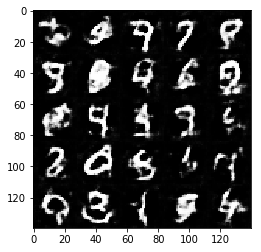

Epoch 1/2... Discriminator Loss: 0.9280... Generator Loss: 0.8653
Epoch 1/2... Discriminator Loss: 0.8973... Generator Loss: 1.8978
Epoch 1/2... Discriminator Loss: 0.9302... Generator Loss: 0.8916
Epoch 1/2... Discriminator Loss: 0.7309... Generator Loss: 1.6245
Epoch 1/2... Discriminator Loss: 0.9133... Generator Loss: 0.9279
Epoch 1/2... Discriminator Loss: 0.7811... Generator Loss: 1.3081
Epoch 1/2... Discriminator Loss: 0.9403... Generator Loss: 0.8800
Epoch 1/2... Discriminator Loss: 1.5760... Generator Loss: 3.1387
Epoch 1/2... Discriminator Loss: 0.8212... Generator Loss: 1.2040
Epoch 1/2... Discriminator Loss: 0.7329... Generator Loss: 1.4462
Epoch 1/2... Discriminator Loss: 0.8296... Generator Loss: 1.0428
Epoch 1/2... Discriminator Loss: 0.7988... Generator Loss: 1.1753
Epoch 1/2... Discriminator Loss: 1.0214... Generator Loss: 2.4885
Epoch 1/2... Discriminator Loss: 0.8833... Generator Loss: 0.9880
Epoch 1/2... Discriminator Loss: 1.0376... Generator Loss: 2.3984
Epoch 1/2.

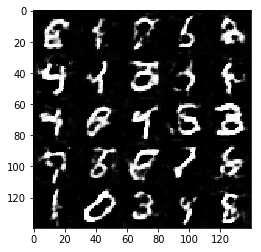

Epoch 1/2... Discriminator Loss: 0.8233... Generator Loss: 1.0192
Epoch 1/2... Discriminator Loss: 0.8814... Generator Loss: 1.7855
Epoch 1/2... Discriminator Loss: 0.7518... Generator Loss: 1.4623
Epoch 1/2... Discriminator Loss: 1.2853... Generator Loss: 0.6522
Epoch 1/2... Discriminator Loss: 0.7715... Generator Loss: 1.6825
Epoch 1/2... Discriminator Loss: 0.7614... Generator Loss: 1.6297
Epoch 1/2... Discriminator Loss: 0.7968... Generator Loss: 1.3136
Epoch 1/2... Discriminator Loss: 0.9591... Generator Loss: 2.1532
Epoch 1/2... Discriminator Loss: 0.6993... Generator Loss: 1.4769
Epoch 1/2... Discriminator Loss: 0.7632... Generator Loss: 1.2251
Epoch 1/2... Discriminator Loss: 0.7756... Generator Loss: 1.5287
Epoch 1/2... Discriminator Loss: 0.7947... Generator Loss: 1.6150
Epoch 1/2... Discriminator Loss: 1.4552... Generator Loss: 0.5765
Epoch 1/2... Discriminator Loss: 0.9219... Generator Loss: 1.0982
Epoch 1/2... Discriminator Loss: 0.8045... Generator Loss: 1.5805
Epoch 1/2.

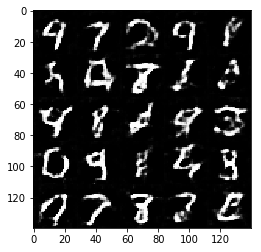

Epoch 1/2... Discriminator Loss: 0.7134... Generator Loss: 1.8492
Epoch 1/2... Discriminator Loss: 1.0512... Generator Loss: 0.9095
Epoch 1/2... Discriminator Loss: 0.8116... Generator Loss: 2.1314
Epoch 1/2... Discriminator Loss: 0.7074... Generator Loss: 1.4681
Epoch 1/2... Discriminator Loss: 1.2507... Generator Loss: 0.6056
Epoch 1/2... Discriminator Loss: 0.7963... Generator Loss: 1.4359
Epoch 1/2... Discriminator Loss: 0.8964... Generator Loss: 1.0215
Epoch 1/2... Discriminator Loss: 0.8335... Generator Loss: 1.2247
Epoch 1/2... Discriminator Loss: 0.8685... Generator Loss: 1.0505
Epoch 1/2... Discriminator Loss: 1.0378... Generator Loss: 0.8513
Epoch 1/2... Discriminator Loss: 1.0951... Generator Loss: 2.5468
Epoch 1/2... Discriminator Loss: 0.7119... Generator Loss: 1.6535
Epoch 1/2... Discriminator Loss: 1.1362... Generator Loss: 0.6889
Epoch 1/2... Discriminator Loss: 0.8104... Generator Loss: 2.0242
Epoch 1/2... Discriminator Loss: 0.9230... Generator Loss: 2.3825
Epoch 1/2.

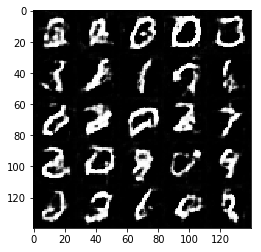

Epoch 1/2... Discriminator Loss: 0.7104... Generator Loss: 1.3108
Epoch 1/2... Discriminator Loss: 0.7576... Generator Loss: 1.1945
Epoch 1/2... Discriminator Loss: 0.6550... Generator Loss: 1.6416
Epoch 1/2... Discriminator Loss: 0.7480... Generator Loss: 1.2516
Epoch 1/2... Discriminator Loss: 0.7284... Generator Loss: 1.1901
Epoch 1/2... Discriminator Loss: 0.8414... Generator Loss: 1.0442
Epoch 1/2... Discriminator Loss: 0.8661... Generator Loss: 2.6942
Epoch 1/2... Discriminator Loss: 1.0942... Generator Loss: 0.7502
Epoch 1/2... Discriminator Loss: 0.9176... Generator Loss: 2.0670
Epoch 1/2... Discriminator Loss: 1.0266... Generator Loss: 3.1504
Epoch 1/2... Discriminator Loss: 1.4904... Generator Loss: 0.5466
Epoch 1/2... Discriminator Loss: 0.7141... Generator Loss: 1.7215
Epoch 1/2... Discriminator Loss: 0.8357... Generator Loss: 1.1172
Epoch 1/2... Discriminator Loss: 0.7852... Generator Loss: 1.1879
Epoch 1/2... Discriminator Loss: 0.7103... Generator Loss: 1.4804
Epoch 1/2.

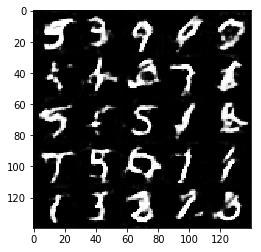

Epoch 1/2... Discriminator Loss: 0.6831... Generator Loss: 1.2528
Epoch 1/2... Discriminator Loss: 1.0009... Generator Loss: 2.8586
Epoch 1/2... Discriminator Loss: 0.7833... Generator Loss: 1.1660
Epoch 1/2... Discriminator Loss: 0.7373... Generator Loss: 1.1828
Epoch 1/2... Discriminator Loss: 0.6378... Generator Loss: 1.8154
Epoch 1/2... Discriminator Loss: 0.6698... Generator Loss: 1.6329
Epoch 1/2... Discriminator Loss: 0.6754... Generator Loss: 1.4245
Epoch 1/2... Discriminator Loss: 0.6103... Generator Loss: 1.5980
Epoch 1/2... Discriminator Loss: 0.8709... Generator Loss: 2.4226
Epoch 1/2... Discriminator Loss: 0.8681... Generator Loss: 1.1089
Epoch 1/2... Discriminator Loss: 0.7683... Generator Loss: 1.5317
Epoch 1/2... Discriminator Loss: 0.5965... Generator Loss: 1.8317
Epoch 1/2... Discriminator Loss: 1.0292... Generator Loss: 0.7878
Epoch 1/2... Discriminator Loss: 0.6196... Generator Loss: 1.5720
Epoch 1/2... Discriminator Loss: 0.9300... Generator Loss: 0.9575
Epoch 1/2.

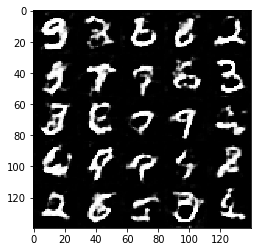

Epoch 1/2... Discriminator Loss: 0.6591... Generator Loss: 1.5342
Epoch 1/2... Discriminator Loss: 0.6627... Generator Loss: 2.0606
Epoch 1/2... Discriminator Loss: 1.3002... Generator Loss: 0.6681
Epoch 1/2... Discriminator Loss: 2.9128... Generator Loss: 4.3897
Epoch 1/2... Discriminator Loss: 0.9116... Generator Loss: 1.0681
Epoch 1/2... Discriminator Loss: 1.0256... Generator Loss: 0.8887
Epoch 1/2... Discriminator Loss: 0.8473... Generator Loss: 1.0075
Epoch 1/2... Discriminator Loss: 0.8201... Generator Loss: 1.0852
Epoch 1/2... Discriminator Loss: 0.6964... Generator Loss: 1.2915
Epoch 1/2... Discriminator Loss: 0.8048... Generator Loss: 1.0592
Epoch 1/2... Discriminator Loss: 0.7405... Generator Loss: 1.2472
Epoch 1/2... Discriminator Loss: 0.7062... Generator Loss: 2.0327
Epoch 2/2... Discriminator Loss: 0.6482... Generator Loss: 1.9094
Epoch 2/2... Discriminator Loss: 0.6336... Generator Loss: 1.9187
Epoch 2/2... Discriminator Loss: 0.6646... Generator Loss: 1.9111
Epoch 2/2.

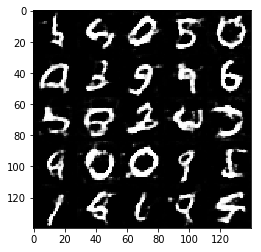

Epoch 2/2... Discriminator Loss: 0.6637... Generator Loss: 1.3954
Epoch 2/2... Discriminator Loss: 0.7834... Generator Loss: 1.0880
Epoch 2/2... Discriminator Loss: 0.6299... Generator Loss: 1.4330
Epoch 2/2... Discriminator Loss: 0.6583... Generator Loss: 1.2968
Epoch 2/2... Discriminator Loss: 0.6505... Generator Loss: 1.5197
Epoch 2/2... Discriminator Loss: 0.5568... Generator Loss: 1.6068
Epoch 2/2... Discriminator Loss: 1.0814... Generator Loss: 0.7718
Epoch 2/2... Discriminator Loss: 0.6620... Generator Loss: 1.9086
Epoch 2/2... Discriminator Loss: 0.7042... Generator Loss: 1.2301
Epoch 2/2... Discriminator Loss: 0.8021... Generator Loss: 1.1462
Epoch 2/2... Discriminator Loss: 0.5883... Generator Loss: 1.9864
Epoch 2/2... Discriminator Loss: 0.6029... Generator Loss: 1.8218
Epoch 2/2... Discriminator Loss: 0.6080... Generator Loss: 1.5135
Epoch 2/2... Discriminator Loss: 0.8468... Generator Loss: 1.0510
Epoch 2/2... Discriminator Loss: 0.6858... Generator Loss: 1.3232
Epoch 2/2.

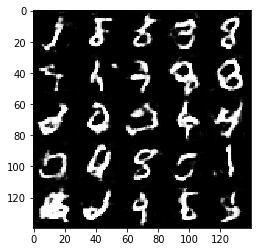

Epoch 2/2... Discriminator Loss: 0.6770... Generator Loss: 1.3969
Epoch 2/2... Discriminator Loss: 0.8310... Generator Loss: 2.5525
Epoch 2/2... Discriminator Loss: 1.4991... Generator Loss: 0.6355
Epoch 2/2... Discriminator Loss: 0.8221... Generator Loss: 1.4888
Epoch 2/2... Discriminator Loss: 0.8872... Generator Loss: 1.6635
Epoch 2/2... Discriminator Loss: 0.7353... Generator Loss: 1.3928
Epoch 2/2... Discriminator Loss: 0.6001... Generator Loss: 2.0008
Epoch 2/2... Discriminator Loss: 0.6366... Generator Loss: 1.8955
Epoch 2/2... Discriminator Loss: 0.6033... Generator Loss: 1.8557
Epoch 2/2... Discriminator Loss: 1.0261... Generator Loss: 2.2277
Epoch 2/2... Discriminator Loss: 0.6222... Generator Loss: 1.8392
Epoch 2/2... Discriminator Loss: 0.6287... Generator Loss: 1.7237
Epoch 2/2... Discriminator Loss: 0.6329... Generator Loss: 1.5797
Epoch 2/2... Discriminator Loss: 0.5307... Generator Loss: 1.9437
Epoch 2/2... Discriminator Loss: 0.6853... Generator Loss: 1.3308
Epoch 2/2.

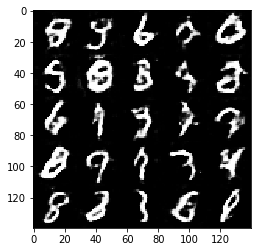

Epoch 2/2... Discriminator Loss: 0.6369... Generator Loss: 1.8929
Epoch 2/2... Discriminator Loss: 0.5876... Generator Loss: 1.7082
Epoch 2/2... Discriminator Loss: 0.6624... Generator Loss: 2.4852
Epoch 2/2... Discriminator Loss: 0.5461... Generator Loss: 2.0757
Epoch 2/2... Discriminator Loss: 0.5928... Generator Loss: 2.0121
Epoch 2/2... Discriminator Loss: 0.5420... Generator Loss: 1.7864
Epoch 2/2... Discriminator Loss: 0.5347... Generator Loss: 2.0812
Epoch 2/2... Discriminator Loss: 0.6195... Generator Loss: 1.5398
Epoch 2/2... Discriminator Loss: 0.8134... Generator Loss: 1.2117
Epoch 2/2... Discriminator Loss: 0.5263... Generator Loss: 1.8505
Epoch 2/2... Discriminator Loss: 0.5628... Generator Loss: 1.9488
Epoch 2/2... Discriminator Loss: 0.5189... Generator Loss: 2.4055
Epoch 2/2... Discriminator Loss: 0.8295... Generator Loss: 1.1574
Epoch 2/2... Discriminator Loss: 0.5513... Generator Loss: 2.0616
Epoch 2/2... Discriminator Loss: 0.7102... Generator Loss: 1.2062
Epoch 2/2.

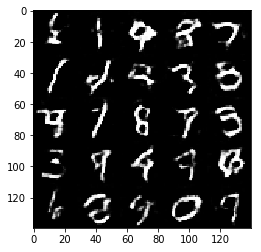

Epoch 2/2... Discriminator Loss: 0.7731... Generator Loss: 1.3422
Epoch 2/2... Discriminator Loss: 0.7713... Generator Loss: 2.2876
Epoch 2/2... Discriminator Loss: 0.7646... Generator Loss: 1.2875
Epoch 2/2... Discriminator Loss: 0.6926... Generator Loss: 1.3524
Epoch 2/2... Discriminator Loss: 0.6682... Generator Loss: 1.3864
Epoch 2/2... Discriminator Loss: 0.6220... Generator Loss: 1.5064
Epoch 2/2... Discriminator Loss: 0.5058... Generator Loss: 2.1069
Epoch 2/2... Discriminator Loss: 0.6075... Generator Loss: 1.8147
Epoch 2/2... Discriminator Loss: 0.7121... Generator Loss: 1.2307
Epoch 2/2... Discriminator Loss: 0.6473... Generator Loss: 1.4678
Epoch 2/2... Discriminator Loss: 0.6014... Generator Loss: 1.8407
Epoch 2/2... Discriminator Loss: 0.5890... Generator Loss: 1.5973
Epoch 2/2... Discriminator Loss: 0.7189... Generator Loss: 1.2194
Epoch 2/2... Discriminator Loss: 0.6364... Generator Loss: 1.3519
Epoch 2/2... Discriminator Loss: 0.5845... Generator Loss: 1.7457
Epoch 2/2.

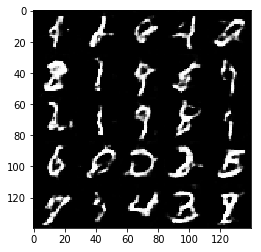

Epoch 2/2... Discriminator Loss: 0.7028... Generator Loss: 1.2014
Epoch 2/2... Discriminator Loss: 0.7177... Generator Loss: 1.1642
Epoch 2/2... Discriminator Loss: 0.6436... Generator Loss: 1.3046
Epoch 2/2... Discriminator Loss: 0.6891... Generator Loss: 1.2579
Epoch 2/2... Discriminator Loss: 0.7059... Generator Loss: 1.3003
Epoch 2/2... Discriminator Loss: 0.5235... Generator Loss: 1.8576
Epoch 2/2... Discriminator Loss: 0.6101... Generator Loss: 1.5825
Epoch 2/2... Discriminator Loss: 0.6378... Generator Loss: 1.7470
Epoch 2/2... Discriminator Loss: 0.5855... Generator Loss: 1.5936
Epoch 2/2... Discriminator Loss: 0.5767... Generator Loss: 1.7428
Epoch 2/2... Discriminator Loss: 0.6817... Generator Loss: 1.2861
Epoch 2/2... Discriminator Loss: 0.6869... Generator Loss: 1.2112
Epoch 2/2... Discriminator Loss: 0.5299... Generator Loss: 1.8514
Epoch 2/2... Discriminator Loss: 0.5747... Generator Loss: 1.6827
Epoch 2/2... Discriminator Loss: 0.5229... Generator Loss: 1.9299
Epoch 2/2.

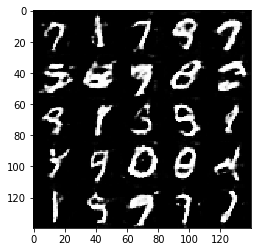

Epoch 2/2... Discriminator Loss: 0.5226... Generator Loss: 2.2642
Epoch 2/2... Discriminator Loss: 0.5904... Generator Loss: 1.8863
Epoch 2/2... Discriminator Loss: 0.5304... Generator Loss: 1.7378
Epoch 2/2... Discriminator Loss: 0.5331... Generator Loss: 1.7309
Epoch 2/2... Discriminator Loss: 0.7021... Generator Loss: 1.1880
Epoch 2/2... Discriminator Loss: 0.5655... Generator Loss: 2.0768
Epoch 2/2... Discriminator Loss: 0.4970... Generator Loss: 2.1717
Epoch 2/2... Discriminator Loss: 0.9161... Generator Loss: 1.0032
Epoch 2/2... Discriminator Loss: 2.3825... Generator Loss: 4.2162
Epoch 2/2... Discriminator Loss: 0.9994... Generator Loss: 1.1567
Epoch 2/2... Discriminator Loss: 0.7546... Generator Loss: 1.7783
Epoch 2/2... Discriminator Loss: 1.2356... Generator Loss: 0.6951
Epoch 2/2... Discriminator Loss: 0.6587... Generator Loss: 1.4607
Epoch 2/2... Discriminator Loss: 0.6538... Generator Loss: 1.6202
Epoch 2/2... Discriminator Loss: 0.5613... Generator Loss: 1.8168
Epoch 2/2.

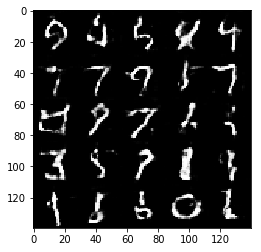

Epoch 2/2... Discriminator Loss: 0.5351... Generator Loss: 1.9399
Epoch 2/2... Discriminator Loss: 0.5675... Generator Loss: 1.6747
Epoch 2/2... Discriminator Loss: 0.5798... Generator Loss: 1.4758
Epoch 2/2... Discriminator Loss: 0.6839... Generator Loss: 1.8277
Epoch 2/2... Discriminator Loss: 0.5680... Generator Loss: 1.9424
Epoch 2/2... Discriminator Loss: 0.5915... Generator Loss: 2.2960
Epoch 2/2... Discriminator Loss: 0.7089... Generator Loss: 1.6316
Epoch 2/2... Discriminator Loss: 0.6339... Generator Loss: 1.3462
Epoch 2/2... Discriminator Loss: 0.5439... Generator Loss: 1.7622
Epoch 2/2... Discriminator Loss: 0.6188... Generator Loss: 2.7957
Epoch 2/2... Discriminator Loss: 1.3888... Generator Loss: 0.5952
Epoch 2/2... Discriminator Loss: 6.3293... Generator Loss: 7.8892
Epoch 2/2... Discriminator Loss: 2.2840... Generator Loss: 4.1080
Epoch 2/2... Discriminator Loss: 0.9589... Generator Loss: 2.2093
Epoch 2/2... Discriminator Loss: 0.8574... Generator Loss: 1.0982
Epoch 2/2.

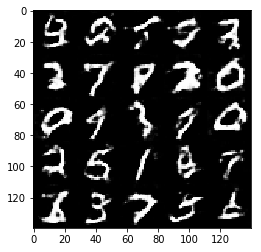

Epoch 2/2... Discriminator Loss: 0.5571... Generator Loss: 1.6806
Epoch 2/2... Discriminator Loss: 0.6655... Generator Loss: 1.4857
Epoch 2/2... Discriminator Loss: 0.5811... Generator Loss: 1.6901
Epoch 2/2... Discriminator Loss: 0.6189... Generator Loss: 1.4885
Epoch 2/2... Discriminator Loss: 0.5673... Generator Loss: 1.6549
Epoch 2/2... Discriminator Loss: 0.5134... Generator Loss: 1.9010
Epoch 2/2... Discriminator Loss: 0.5528... Generator Loss: 1.8202
Epoch 2/2... Discriminator Loss: 0.5931... Generator Loss: 1.5979
Epoch 2/2... Discriminator Loss: 0.6021... Generator Loss: 1.5300
Epoch 2/2... Discriminator Loss: 0.5386... Generator Loss: 1.8506
Epoch 2/2... Discriminator Loss: 0.5608... Generator Loss: 1.7649
Epoch 2/2... Discriminator Loss: 0.5966... Generator Loss: 1.6017
Epoch 2/2... Discriminator Loss: 0.5808... Generator Loss: 1.6457
Epoch 2/2... Discriminator Loss: 0.5678... Generator Loss: 1.8576
Epoch 2/2... Discriminator Loss: 0.5696... Generator Loss: 2.1464
Epoch 2/2.

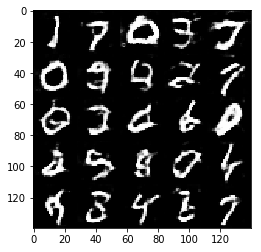

Epoch 2/2... Discriminator Loss: 0.6746... Generator Loss: 1.3473
Epoch 2/2... Discriminator Loss: 0.5868... Generator Loss: 1.5325
Epoch 2/2... Discriminator Loss: 0.6327... Generator Loss: 1.4572
Epoch 2/2... Discriminator Loss: 0.5811... Generator Loss: 1.4645
Epoch 2/2... Discriminator Loss: 0.7411... Generator Loss: 1.1997
Epoch 2/2... Discriminator Loss: 0.7954... Generator Loss: 1.0124
Epoch 2/2... Discriminator Loss: 0.6351... Generator Loss: 1.3329
Epoch 2/2... Discriminator Loss: 0.5486... Generator Loss: 1.7661
Epoch 2/2... Discriminator Loss: 0.5668... Generator Loss: 1.8165
Epoch 2/2... Discriminator Loss: 0.5210... Generator Loss: 1.8148
Epoch 2/2... Discriminator Loss: 0.5952... Generator Loss: 1.7016
Epoch 2/2... Discriminator Loss: 0.5393... Generator Loss: 1.8757
Epoch 2/2... Discriminator Loss: 0.6311... Generator Loss: 1.3964
Epoch 2/2... Discriminator Loss: 0.5176... Generator Loss: 2.0031
Epoch 2/2... Discriminator Loss: 0.5644... Generator Loss: 1.6565
Epoch 2/2.

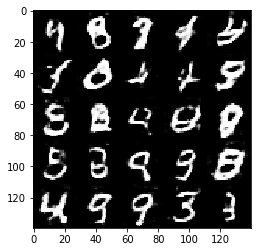

Epoch 2/2... Discriminator Loss: 0.5371... Generator Loss: 1.7862
Epoch 2/2... Discriminator Loss: 0.5552... Generator Loss: 1.7568
Epoch 2/2... Discriminator Loss: 0.5703... Generator Loss: 1.5652
Epoch 2/2... Discriminator Loss: 1.0090... Generator Loss: 0.9186
Epoch 2/2... Discriminator Loss: 0.6170... Generator Loss: 2.1968
Epoch 2/2... Discriminator Loss: 3.3800... Generator Loss: 0.3880
Epoch 2/2... Discriminator Loss: 0.7873... Generator Loss: 2.2588
Epoch 2/2... Discriminator Loss: 0.8037... Generator Loss: 2.2651
Epoch 2/2... Discriminator Loss: 0.8599... Generator Loss: 2.2726
Epoch 2/2... Discriminator Loss: 0.6775... Generator Loss: 2.2035
Epoch 2/2... Discriminator Loss: 0.8285... Generator Loss: 1.0775
Epoch 2/2... Discriminator Loss: 0.6310... Generator Loss: 1.4915
Epoch 2/2... Discriminator Loss: 0.5730... Generator Loss: 1.9517
Epoch 2/2... Discriminator Loss: 0.6774... Generator Loss: 1.1823
Epoch 2/2... Discriminator Loss: 0.6250... Generator Loss: 1.4097
Epoch 2/2.

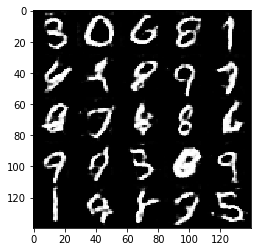

Epoch 2/2... Discriminator Loss: 0.5333... Generator Loss: 1.8328
Epoch 2/2... Discriminator Loss: 0.5553... Generator Loss: 2.1438
Epoch 2/2... Discriminator Loss: 0.5524... Generator Loss: 1.8785
Epoch 2/2... Discriminator Loss: 0.6687... Generator Loss: 2.2205
Epoch 2/2... Discriminator Loss: 0.5086... Generator Loss: 1.9159
Epoch 2/2... Discriminator Loss: 0.5558... Generator Loss: 1.6774
Epoch 2/2... Discriminator Loss: 0.7027... Generator Loss: 1.2322
Epoch 2/2... Discriminator Loss: 0.5975... Generator Loss: 1.4516
Epoch 2/2... Discriminator Loss: 0.6128... Generator Loss: 1.5992
Epoch 2/2... Discriminator Loss: 0.5418... Generator Loss: 1.5766
Epoch 2/2... Discriminator Loss: 0.6135... Generator Loss: 1.4864
Epoch 2/2... Discriminator Loss: 0.6885... Generator Loss: 1.2251
Epoch 2/2... Discriminator Loss: 0.8020... Generator Loss: 1.0915
Epoch 2/2... Discriminator Loss: 3.8464... Generator Loss: 6.4586
Epoch 2/2... Discriminator Loss: 1.6880... Generator Loss: 0.5424
Epoch 2/2.

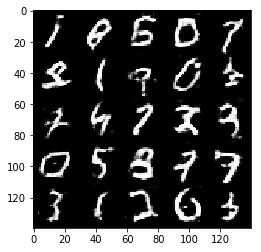

Epoch 2/2... Discriminator Loss: 0.5656... Generator Loss: 1.9025
Epoch 2/2... Discriminator Loss: 0.7142... Generator Loss: 1.2024
Epoch 2/2... Discriminator Loss: 0.5462... Generator Loss: 1.8007
Epoch 2/2... Discriminator Loss: 0.5518... Generator Loss: 1.7638
Epoch 2/2... Discriminator Loss: 0.5589... Generator Loss: 1.6430
Epoch 2/2... Discriminator Loss: 0.5423... Generator Loss: 2.0563
Epoch 2/2... Discriminator Loss: 0.6371... Generator Loss: 1.3916
Epoch 2/2... Discriminator Loss: 0.5119... Generator Loss: 1.9828
Epoch 2/2... Discriminator Loss: 0.5550... Generator Loss: 1.6729
Epoch 2/2... Discriminator Loss: 0.5945... Generator Loss: 1.4801
Epoch 2/2... Discriminator Loss: 0.6184... Generator Loss: 1.3793
Epoch 2/2... Discriminator Loss: 0.5820... Generator Loss: 1.8741
Epoch 2/2... Discriminator Loss: 0.7625... Generator Loss: 1.1342
Epoch 2/2... Discriminator Loss: 0.4829... Generator Loss: 1.9823
Epoch 2/2... Discriminator Loss: 0.7302... Generator Loss: 1.1659
Epoch 2/2.

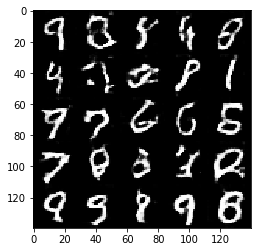

Epoch 2/2... Discriminator Loss: 0.6452... Generator Loss: 1.6328
Epoch 2/2... Discriminator Loss: 0.7157... Generator Loss: 1.2866
Epoch 2/2... Discriminator Loss: 0.5299... Generator Loss: 1.9118
Epoch 2/2... Discriminator Loss: 0.6007... Generator Loss: 1.5267
Epoch 2/2... Discriminator Loss: 0.5052... Generator Loss: 2.1998
Epoch 2/2... Discriminator Loss: 0.5566... Generator Loss: 1.7216
Epoch 2/2... Discriminator Loss: 0.7695... Generator Loss: 1.0922
Epoch 2/2... Discriminator Loss: 1.5151... Generator Loss: 3.5190
Epoch 2/2... Discriminator Loss: 0.8877... Generator Loss: 1.4257
Epoch 2/2... Discriminator Loss: 0.9322... Generator Loss: 1.0618
Epoch 2/2... Discriminator Loss: 1.3449... Generator Loss: 0.6683
Epoch 2/2... Discriminator Loss: 0.7210... Generator Loss: 1.3833
Epoch 2/2... Discriminator Loss: 0.9473... Generator Loss: 0.8421
Epoch 2/2... Discriminator Loss: 0.7986... Generator Loss: 1.9532
Epoch 2/2... Discriminator Loss: 0.5978... Generator Loss: 1.5826
Epoch 2/2.

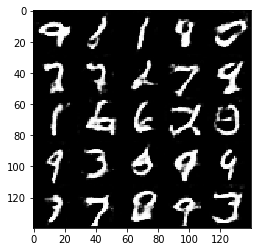

Epoch 2/2... Discriminator Loss: 0.6797... Generator Loss: 1.3473
Epoch 2/2... Discriminator Loss: 0.8372... Generator Loss: 1.0219
Epoch 2/2... Discriminator Loss: 0.6308... Generator Loss: 1.5460
Epoch 2/2... Discriminator Loss: 0.5272... Generator Loss: 1.9801
Epoch 2/2... Discriminator Loss: 0.6494... Generator Loss: 1.4220
Epoch 2/2... Discriminator Loss: 0.6659... Generator Loss: 1.3505
Epoch 2/2... Discriminator Loss: 0.8094... Generator Loss: 1.1596
Epoch 2/2... Discriminator Loss: 1.1151... Generator Loss: 2.9124
Epoch 2/2... Discriminator Loss: 0.7212... Generator Loss: 2.5255
Epoch 2/2... Discriminator Loss: 0.6782... Generator Loss: 1.6118
Epoch 2/2... Discriminator Loss: 0.5903... Generator Loss: 1.9575
Epoch 2/2... Discriminator Loss: 0.6645... Generator Loss: 1.3005
Epoch 2/2... Discriminator Loss: 0.6776... Generator Loss: 1.3193
Epoch 2/2... Discriminator Loss: 0.5967... Generator Loss: 1.5073
Epoch 2/2... Discriminator Loss: 0.5057... Generator Loss: 2.0876
Epoch 2/2.

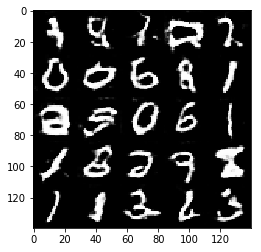

Epoch 2/2... Discriminator Loss: 0.6295... Generator Loss: 1.3767
Epoch 2/2... Discriminator Loss: 0.5500... Generator Loss: 1.7366
Epoch 2/2... Discriminator Loss: 0.6905... Generator Loss: 1.2636
Epoch 2/2... Discriminator Loss: 0.6543... Generator Loss: 1.3160
Epoch 2/2... Discriminator Loss: 0.6329... Generator Loss: 2.5267
Epoch 2/2... Discriminator Loss: 0.5801... Generator Loss: 1.9235
Epoch 2/2... Discriminator Loss: 0.5969... Generator Loss: 1.4038
Epoch 2/2... Discriminator Loss: 0.6182... Generator Loss: 1.6429
Epoch 2/2... Discriminator Loss: 0.6230... Generator Loss: 1.5477
Epoch 2/2... Discriminator Loss: 0.6088... Generator Loss: 1.4606
Epoch 2/2... Discriminator Loss: 0.5414... Generator Loss: 1.6391
Epoch 2/2... Discriminator Loss: 0.5180... Generator Loss: 2.0811
Epoch 2/2... Discriminator Loss: 0.5270... Generator Loss: 1.7765
Epoch 2/2... Discriminator Loss: 0.5962... Generator Loss: 1.5544
Epoch 2/2... Discriminator Loss: 0.5148... Generator Loss: 2.5566
Epoch 2/2.

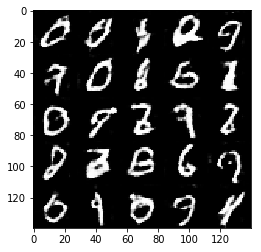

Epoch 2/2... Discriminator Loss: 1.2246... Generator Loss: 0.6671
Epoch 2/2... Discriminator Loss: 0.8346... Generator Loss: 1.1958
Epoch 2/2... Discriminator Loss: 0.7730... Generator Loss: 1.2158
Epoch 2/2... Discriminator Loss: 0.9662... Generator Loss: 0.9205


IndexError: list index out of range

In [ ]:
batch_size = 64
z_dim = 100
learning_rate = 0.001 # 0.0002
beta1 = 0.3 # 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 13.7706... Generator Loss: 1.2577
Epoch 1/1... Discriminator Loss: 2.7167... Generator Loss: 9.6276
Epoch 1/1... Discriminator Loss: 3.5411... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.8731... Generator Loss: 4.3987
Epoch 1/1... Discriminator Loss: 1.1831... Generator Loss: 1.3536
Epoch 1/1... Discriminator Loss: 1.8758... Generator Loss: 0.8496
Epoch 1/1... Discriminator Loss: 3.2076... Generator Loss: 0.3444
Epoch 1/1... Discriminator Loss: 2.1086... Generator Loss: 0.4320
Epoch 1/1... Discriminator Loss: 1.6086... Generator Loss: 0.5914
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 1.9646


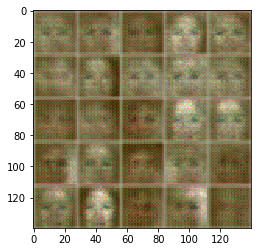

Epoch 1/1... Discriminator Loss: 1.6211... Generator Loss: 0.5451
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 1.5936
Epoch 1/1... Discriminator Loss: 1.6784... Generator Loss: 0.8426
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 1.1411
Epoch 1/1... Discriminator Loss: 1.5126... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.6471... Generator Loss: 0.4781
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 1.5227


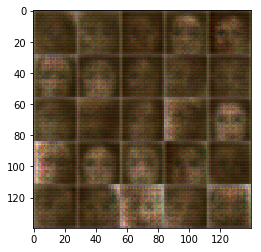

Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.9001
Epoch 1/1... Discriminator Loss: 1.7802... Generator Loss: 0.4541
Epoch 1/1... Discriminator Loss: 1.6706... Generator Loss: 2.2354
Epoch 1/1... Discriminator Loss: 1.0292... Generator Loss: 0.9362
Epoch 1/1... Discriminator Loss: 2.8726... Generator Loss: 3.2666
Epoch 1/1... Discriminator Loss: 1.1772... Generator Loss: 0.8176
Epoch 1/1... Discriminator Loss: 1.6924... Generator Loss: 2.7006
Epoch 1/1... Discriminator Loss: 0.8036... Generator Loss: 1.1572
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 0.8871
Epoch 1/1... Discriminator Loss: 3.0834... Generator Loss: 3.0845


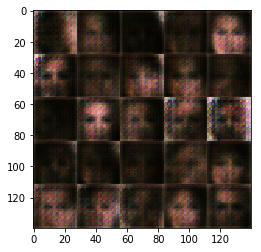

Epoch 1/1... Discriminator Loss: 1.5979... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 1.6106... Generator Loss: 0.5457
Epoch 1/1... Discriminator Loss: 1.4316... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.8971
Epoch 1/1... Discriminator Loss: 1.8313... Generator Loss: 2.0641
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 1.0419
Epoch 1/1... Discriminator Loss: 2.2232... Generator Loss: 0.3675
Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 0.8060
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.8610
Epoch 1/1... Discriminator Loss: 1.6542... Generator Loss: 2.8747


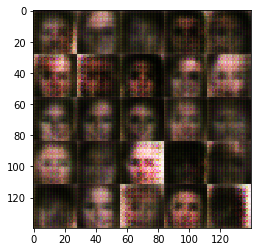

Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.5859... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.3291... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 2.0189... Generator Loss: 0.3690
Epoch 1/1... Discriminator Loss: 1.0113... Generator Loss: 1.0266
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 1.8031
Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 1.3186
Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.8675
Epoch 1/1... Discriminator Loss: 1.2959... Generator Loss: 0.8284


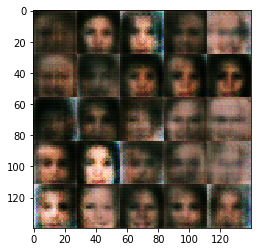

Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.8070
Epoch 1/1... Discriminator Loss: 0.8952... Generator Loss: 1.3761
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 2.1567... Generator Loss: 1.3915
Epoch 1/1... Discriminator Loss: 1.4943... Generator Loss: 0.8825
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7613


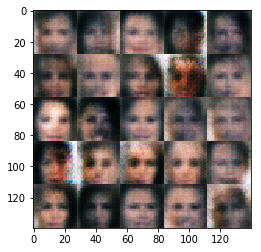

Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.9535
Epoch 1/1... Discriminator Loss: 2.3701... Generator Loss: 1.7620
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.6359... Generator Loss: 1.2737
Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 0.8722
Epoch 1/1... Discriminator Loss: 1.3187... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.7575


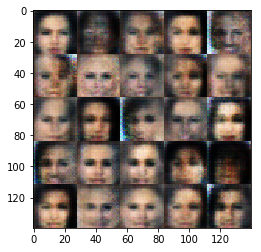

Epoch 1/1... Discriminator Loss: 1.3494... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.3361... Generator Loss: 0.6893
Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 0.8631
Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 0.8563
Epoch 1/1... Discriminator Loss: 0.8566... Generator Loss: 1.2051
Epoch 1/1... Discriminator Loss: 1.0950... Generator Loss: 1.6747
Epoch 1/1... Discriminator Loss: 2.2620... Generator Loss: 0.3643
Epoch 1/1... Discriminator Loss: 1.8585... Generator Loss: 0.5853
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.9821
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.6994


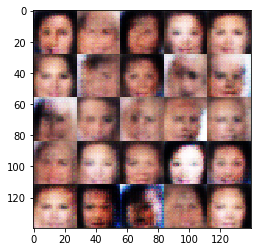

Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.9012
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 0.8992
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.8890
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.8986
Epoch 1/1... Discriminator Loss: 1.0475... Generator Loss: 1.5558
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.5077
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 0.8207


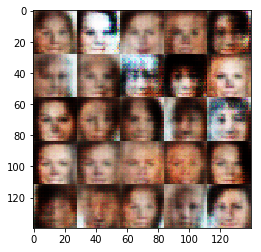

Epoch 1/1... Discriminator Loss: 1.2091... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 0.8203... Generator Loss: 1.4270
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 0.6068
Epoch 1/1... Discriminator Loss: 1.7712... Generator Loss: 1.0424
Epoch 1/1... Discriminator Loss: 1.6227... Generator Loss: 0.8369
Epoch 1/1... Discriminator Loss: 1.3942... Generator Loss: 0.8348
Epoch 1/1... Discriminator Loss: 1.4904... Generator Loss: 0.8158
Epoch 1/1... Discriminator Loss: 1.3116... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.9031


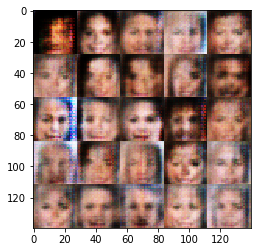

Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.7097
Epoch 1/1... Discriminator Loss: 1.5317... Generator Loss: 0.5937
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.9786
Epoch 1/1... Discriminator Loss: 1.3538... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 1.1189
Epoch 1/1... Discriminator Loss: 1.3172... Generator Loss: 0.5966
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.6073
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 1.2526


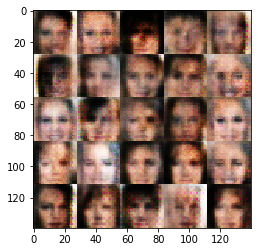

Epoch 1/1... Discriminator Loss: 1.5388... Generator Loss: 0.5436
Epoch 1/1... Discriminator Loss: 1.6439... Generator Loss: 0.4943
Epoch 1/1... Discriminator Loss: 1.5736... Generator Loss: 0.6029
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.8426... Generator Loss: 1.2886
Epoch 1/1... Discriminator Loss: 1.3793... Generator Loss: 0.9549
Epoch 1/1... Discriminator Loss: 1.3779... Generator Loss: 1.0472
Epoch 1/1... Discriminator Loss: 1.1270... Generator Loss: 1.0618
Epoch 1/1... Discriminator Loss: 1.2237... Generator Loss: 0.9911
Epoch 1/1... Discriminator Loss: 1.1176... Generator Loss: 0.7162


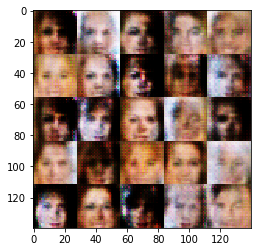

Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.5322
Epoch 1/1... Discriminator Loss: 3.1465... Generator Loss: 2.5941
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 1.6438... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.7913
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.8514
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 1.0114
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.7816


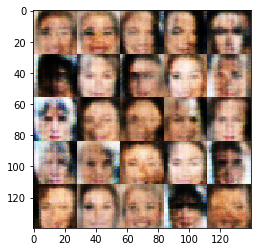

Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.9141
Epoch 1/1... Discriminator Loss: 1.6918... Generator Loss: 0.4515
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.6565
Epoch 1/1... Discriminator Loss: 1.5915... Generator Loss: 1.6204
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.5850... Generator Loss: 0.4953
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.8627
Epoch 1/1... Discriminator Loss: 1.2178... Generator Loss: 0.9527


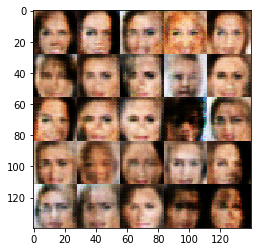

Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 0.8198
Epoch 1/1... Discriminator Loss: 1.0563... Generator Loss: 1.0183
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 0.9968
Epoch 1/1... Discriminator Loss: 1.5049... Generator Loss: 1.2614
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.9844
Epoch 1/1... Discriminator Loss: 1.2840... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.6166... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.8040


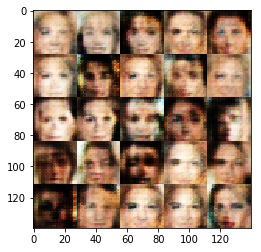

Epoch 1/1... Discriminator Loss: 1.3499... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.3852... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.8332
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 0.9045
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 0.8619
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.9030
Epoch 1/1... Discriminator Loss: 1.6993... Generator Loss: 1.4688


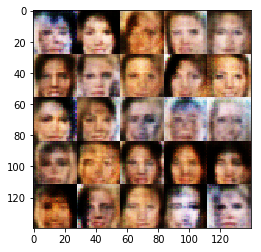

Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.9824
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 1.2375... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 0.8658
Epoch 1/1... Discriminator Loss: 1.0158... Generator Loss: 0.9122
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 1.2135
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.5443
Epoch 1/1... Discriminator Loss: 1.4717... Generator Loss: 0.8623
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.5920
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.6379


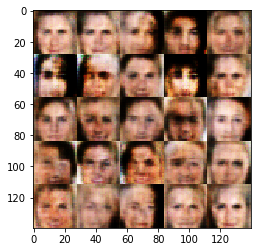

Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 1.2790
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 1.1386
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.5789
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.6004
Epoch 1/1... Discriminator Loss: 1.2583... Generator Loss: 0.9162
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 1.2756
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 0.9411
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.6375


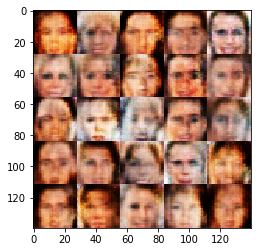

Epoch 1/1... Discriminator Loss: 1.1742... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 2.2576... Generator Loss: 1.6457
Epoch 1/1... Discriminator Loss: 1.5307... Generator Loss: 0.5405
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.2207... Generator Loss: 0.9603
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.9084
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 1.0204
Epoch 1/1... Discriminator Loss: 0.9952... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.5050... Generator Loss: 1.3277
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 1.1130


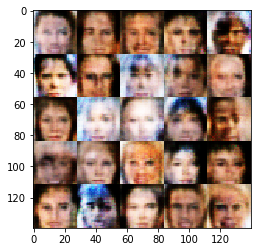

Epoch 1/1... Discriminator Loss: 1.3307... Generator Loss: 0.8654
Epoch 1/1... Discriminator Loss: 1.4182... Generator Loss: 0.8799
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.8243
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.3164... Generator Loss: 0.9621
Epoch 1/1... Discriminator Loss: 1.2060... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.6060
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 1.2845


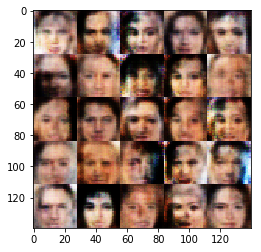

Epoch 1/1... Discriminator Loss: 1.1846... Generator Loss: 0.9125
Epoch 1/1... Discriminator Loss: 0.9183... Generator Loss: 0.8967
Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.5542
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.8684
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 1.2095
Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.8930
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.9749
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.7707


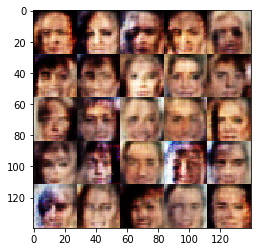

Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.8949
Epoch 1/1... Discriminator Loss: 1.3084... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 0.9111
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.8937


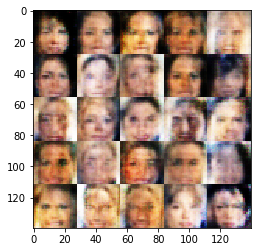

Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.5620
Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.5764... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 1.1807
Epoch 1/1... Discriminator Loss: 1.2057... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 1.2008
Epoch 1/1... Discriminator Loss: 1.2670... Generator Loss: 1.3022
Epoch 1/1... Discriminator Loss: 1.2584... Generator Loss: 0.8201
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.5889


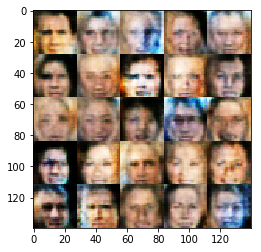

Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 1.9301... Generator Loss: 1.6087
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.9088
Epoch 1/1... Discriminator Loss: 0.7669... Generator Loss: 1.3009
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.5814
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.8448
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.8716
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 0.8994
Epoch 1/1... Discriminator Loss: 1.2815... Generator Loss: 0.9530


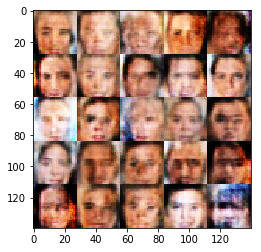

Epoch 1/1... Discriminator Loss: 1.3019... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.2510... Generator Loss: 1.0575
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 1.2942
Epoch 1/1... Discriminator Loss: 1.3796... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.6932
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 1.0311


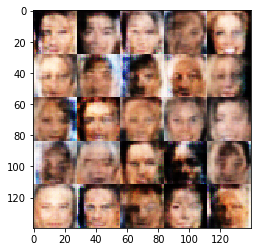

Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.5434
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.5528
Epoch 1/1... Discriminator Loss: 1.5697... Generator Loss: 0.5404
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.5859
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.8105
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.3030... Generator Loss: 1.0184
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 1.0679


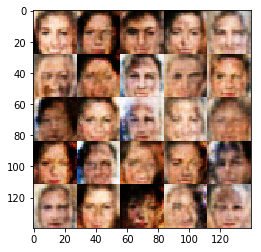

Epoch 1/1... Discriminator Loss: 1.1515... Generator Loss: 0.8441
Epoch 1/1... Discriminator Loss: 1.0337... Generator Loss: 1.0216
Epoch 1/1... Discriminator Loss: 1.2437... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.6824... Generator Loss: 1.3167
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 1.1133
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 0.9068
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.8468
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 1.1887


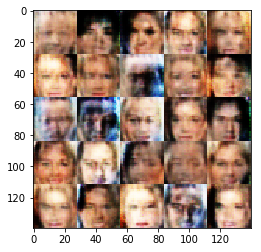

Epoch 1/1... Discriminator Loss: 1.2857... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.2218... Generator Loss: 0.8029
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.6100
Epoch 1/1... Discriminator Loss: 1.3088... Generator Loss: 0.7236
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.8284
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 0.9970
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.5605... Generator Loss: 1.2164
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.7736


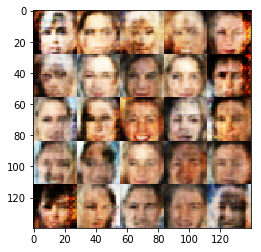

Epoch 1/1... Discriminator Loss: 1.3761... Generator Loss: 0.8098
Epoch 1/1... Discriminator Loss: 1.1271... Generator Loss: 1.2342
Epoch 1/1... Discriminator Loss: 1.2819... Generator Loss: 0.8993
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 0.7290
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.6077
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 1.5342... Generator Loss: 0.8925
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 1.0216
Epoch 1/1... Discriminator Loss: 1.4423... Generator Loss: 1.1552


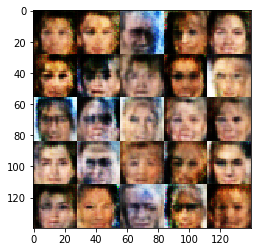

Epoch 1/1... Discriminator Loss: 1.4893... Generator Loss: 0.5460
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 1.1761
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 1.0175
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 1.2051
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 1.2048... Generator Loss: 1.0927
Epoch 1/1... Discriminator Loss: 1.8339... Generator Loss: 1.5481
Epoch 1/1... Discriminator Loss: 1.4507... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 1.2655


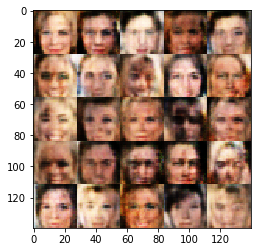

Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 1.2866
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.5375
Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.3901... Generator Loss: 0.8042
Epoch 1/1... Discriminator Loss: 1.0744... Generator Loss: 0.9500
Epoch 1/1... Discriminator Loss: 2.1638... Generator Loss: 1.8479
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.8474
Epoch 1/1... Discriminator Loss: 1.3611... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 1.1546


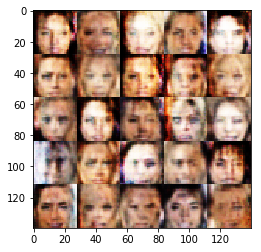

Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.9331
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.8083
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 1.1042
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.9001... Generator Loss: 1.6860
Epoch 1/1... Discriminator Loss: 1.2841... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 0.9674
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 1.0706
Epoch 1/1... Discriminator Loss: 1.5101... Generator Loss: 1.4157
Epoch 1/1... Discriminator Loss: 1.1936... Generator Loss: 0.8769


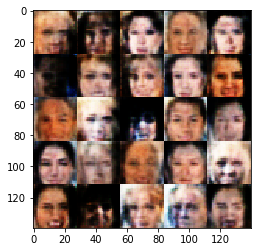

Epoch 1/1... Discriminator Loss: 1.1600... Generator Loss: 1.6112
Epoch 1/1... Discriminator Loss: 0.9122... Generator Loss: 1.3462
Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 0.6217
Epoch 1/1... Discriminator Loss: 1.5790... Generator Loss: 0.5489
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 1.4550... Generator Loss: 0.5917
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 1.2065


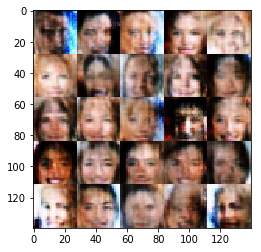

Epoch 1/1... Discriminator Loss: 1.3601... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.6086... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 1.1407... Generator Loss: 0.8497
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 1.3217
Epoch 1/1... Discriminator Loss: 1.1941... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 0.9390
Epoch 1/1... Discriminator Loss: 1.6947... Generator Loss: 1.3395


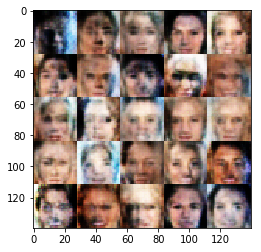

Epoch 1/1... Discriminator Loss: 1.5469... Generator Loss: 0.6254
Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 1.4334
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.7808
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 1.0326
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 1.3221
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 1.0232
Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.9319
Epoch 1/1... Discriminator Loss: 1.3014... Generator Loss: 0.7625


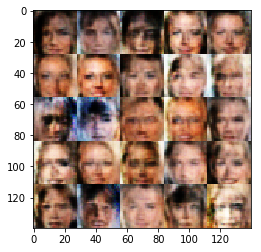

Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.9393
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.6940
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.8170
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 0.7533
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.5580
Epoch 1/1... Discriminator Loss: 1.6490... Generator Loss: 0.4554
Epoch 1/1... Discriminator Loss: 1.1781... Generator Loss: 1.1015
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.9772
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.7501


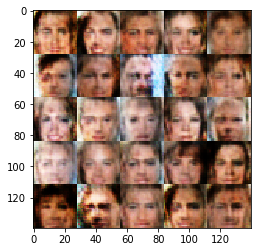

Epoch 1/1... Discriminator Loss: 1.3329... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.3077... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.7908
Epoch 1/1... Discriminator Loss: 1.2983... Generator Loss: 0.6102
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.9589
Epoch 1/1... Discriminator Loss: 1.5621... Generator Loss: 0.4798
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.7599
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 1.2061
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.7165
Epoch 1/1... Discriminator Loss: 1.7716... Generator Loss: 0.4344


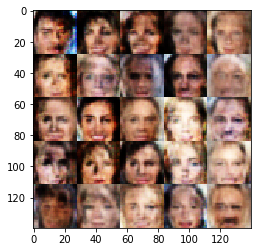

Epoch 1/1... Discriminator Loss: 1.4422... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 0.9387
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 1.1171
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 1.2923
Epoch 1/1... Discriminator Loss: 1.4415... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.2392... Generator Loss: 0.8786
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 1.0827
Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 1.2785
Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 0.8854


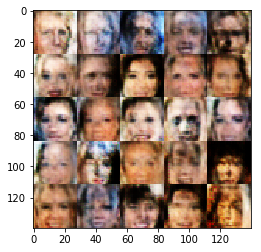

Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 0.9597
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.5807
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 1.0577
Epoch 1/1... Discriminator Loss: 1.3481... Generator Loss: 1.1216
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 0.9537
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 0.9470
Epoch 1/1... Discriminator Loss: 1.5402... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 1.1033
Epoch 1/1... Discriminator Loss: 1.8223... Generator Loss: 0.4050
Epoch 1/1... Discriminator Loss: 1.5272... Generator Loss: 0.5107


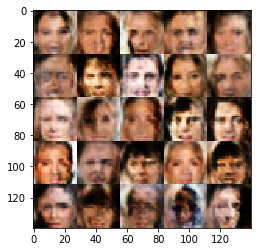

Epoch 1/1... Discriminator Loss: 1.5742... Generator Loss: 0.5016
Epoch 1/1... Discriminator Loss: 1.5412... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.8073
Epoch 1/1... Discriminator Loss: 1.2671... Generator Loss: 0.7609
Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 0.9187
Epoch 1/1... Discriminator Loss: 1.4936... Generator Loss: 1.3055
Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 1.2796
Epoch 1/1... Discriminator Loss: 1.4968... Generator Loss: 0.5300
Epoch 1/1... Discriminator Loss: 1.3949... Generator Loss: 0.6405


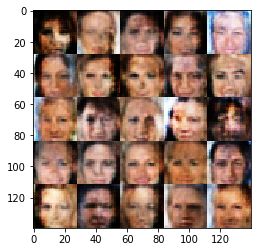

Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 1.1255
Epoch 1/1... Discriminator Loss: 1.3310... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.6433... Generator Loss: 0.5953
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.5273
Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 0.9560
Epoch 1/1... Discriminator Loss: 0.9490... Generator Loss: 1.0937
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.5049
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.6454
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 1.0943


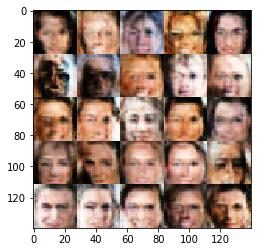

Epoch 1/1... Discriminator Loss: 1.3214... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.1054... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.4296... Generator Loss: 0.6316
Epoch 1/1... Discriminator Loss: 1.5311... Generator Loss: 0.5529
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.5306
Epoch 1/1... Discriminator Loss: 1.4278... Generator Loss: 0.5974
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.2888... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.7931


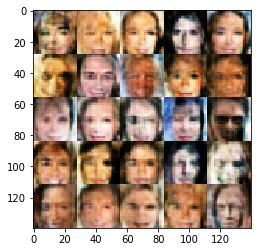

Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 0.9507
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.1957... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.4396... Generator Loss: 0.5156
Epoch 1/1... Discriminator Loss: 1.5312... Generator Loss: 1.0911
Epoch 1/1... Discriminator Loss: 1.4626... Generator Loss: 1.4215


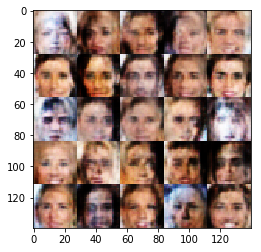

Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.9363
Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.1404... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.7481
Epoch 1/1... Discriminator Loss: 1.5906... Generator Loss: 0.4870
Epoch 1/1... Discriminator Loss: 1.4586... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.8554
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 0.9674
Epoch 1/1... Discriminator Loss: 1.2884... Generator Loss: 0.7965


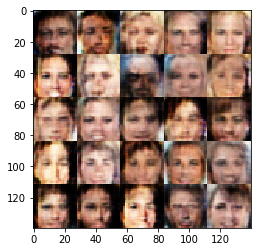

Epoch 1/1... Discriminator Loss: 1.2190... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.0871... Generator Loss: 0.9708
Epoch 1/1... Discriminator Loss: 1.6081... Generator Loss: 1.0904
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.5664... Generator Loss: 1.3942
Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 1.2114
Epoch 1/1... Discriminator Loss: 1.6627... Generator Loss: 1.2033
Epoch 1/1... Discriminator Loss: 1.4284... Generator Loss: 0.7567


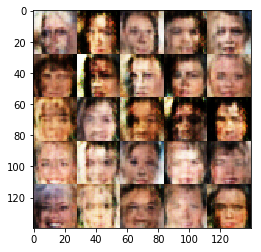

Epoch 1/1... Discriminator Loss: 1.3475... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.3769... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.6065
Epoch 1/1... Discriminator Loss: 1.4351... Generator Loss: 0.5888
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.8827
Epoch 1/1... Discriminator Loss: 1.2766... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.3357... Generator Loss: 0.9718


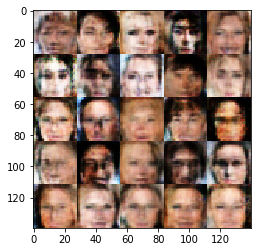

Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.7922
Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 1.0507
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.8676
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.7878
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.8586
Epoch 1/1... Discriminator Loss: 1.2136... Generator Loss: 0.7955
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.6157
Epoch 1/1... Discriminator Loss: 1.3188... Generator Loss: 0.9732


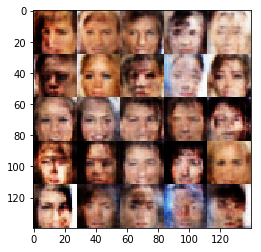

Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 1.0808... Generator Loss: 1.1290
Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.5909
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 0.7869
Epoch 1/1... Discriminator Loss: 1.7994... Generator Loss: 0.4260
Epoch 1/1... Discriminator Loss: 1.4500... Generator Loss: 0.5542
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.9158


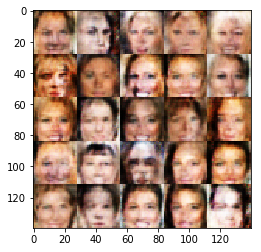

Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.8225
Epoch 1/1... Discriminator Loss: 1.0866... Generator Loss: 0.9677
Epoch 1/1... Discriminator Loss: 1.4383... Generator Loss: 0.8083
Epoch 1/1... Discriminator Loss: 1.7957... Generator Loss: 1.6561
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 0.6447
Epoch 1/1... Discriminator Loss: 1.4619... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.9636
Epoch 1/1... Discriminator Loss: 1.2492... Generator Loss: 0.8684
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.8603


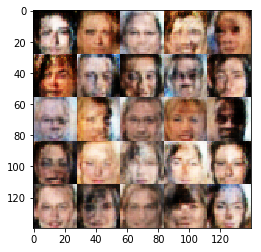

Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.7633
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.8907
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.6156
Epoch 1/1... Discriminator Loss: 1.3016... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.6218... Generator Loss: 1.4556
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 1.2903... Generator Loss: 0.9238
Epoch 1/1... Discriminator Loss: 1.1247... Generator Loss: 0.8663
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 0.9507


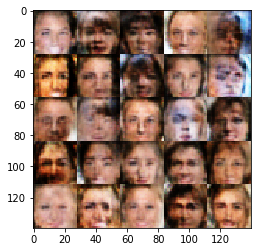

Epoch 1/1... Discriminator Loss: 1.2834... Generator Loss: 0.7115
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.7030... Generator Loss: 1.4860
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.8045
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 1.3747
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.6295
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 1.2266
Epoch 1/1... Discriminator Loss: 1.3258... Generator Loss: 1.1296


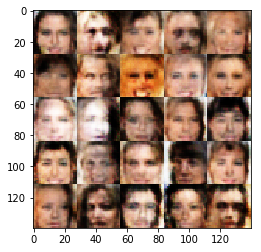

Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 0.8552
Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.9636
Epoch 1/1... Discriminator Loss: 1.2694... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 0.9283
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.9829
Epoch 1/1... Discriminator Loss: 1.6818... Generator Loss: 1.1506
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 1.1025
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.6816


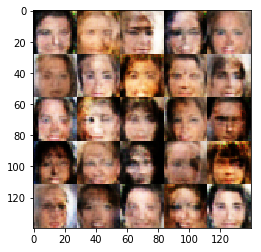

Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.6197
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 0.9029
Epoch 1/1... Discriminator Loss: 1.5699... Generator Loss: 1.4638
Epoch 1/1... Discriminator Loss: 1.2609... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.1690... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 1.0648
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.9490
Epoch 1/1... Discriminator Loss: 1.2348... Generator Loss: 0.8509
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 1.4705


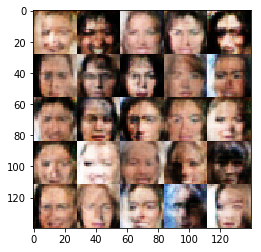

Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 1.1408
Epoch 1/1... Discriminator Loss: 1.0537... Generator Loss: 1.0949
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.8547
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.9496
Epoch 1/1... Discriminator Loss: 1.5359... Generator Loss: 0.4791
Epoch 1/1... Discriminator Loss: 1.4816... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.0275... Generator Loss: 0.9689
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 0.6006
Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 0.9016
Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.7644


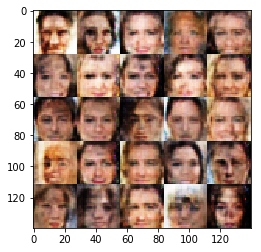

Epoch 1/1... Discriminator Loss: 1.4070... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 0.8436
Epoch 1/1... Discriminator Loss: 2.1230... Generator Loss: 1.9246
Epoch 1/1... Discriminator Loss: 1.2249... Generator Loss: 0.8459
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 1.0981
Epoch 1/1... Discriminator Loss: 1.2219... Generator Loss: 0.8672
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 0.8256
Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.9613... Generator Loss: 1.6496


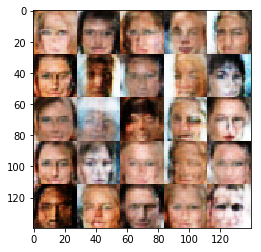

Epoch 1/1... Discriminator Loss: 1.1414... Generator Loss: 0.8904
Epoch 1/1... Discriminator Loss: 1.1812... Generator Loss: 0.8329
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 0.9116
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 1.2023
Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 1.0131
Epoch 1/1... Discriminator Loss: 1.2368... Generator Loss: 0.7027


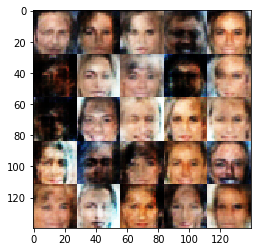

Epoch 1/1... Discriminator Loss: 1.2617... Generator Loss: 0.5900
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.9901
Epoch 1/1... Discriminator Loss: 1.1504... Generator Loss: 0.9106
Epoch 1/1... Discriminator Loss: 1.6159... Generator Loss: 0.4766
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.9537
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.9333
Epoch 1/1... Discriminator Loss: 1.3794... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.7677


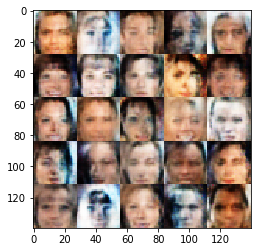

Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.6052
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.4399... Generator Loss: 0.5328
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 0.9771
Epoch 1/1... Discriminator Loss: 1.2302... Generator Loss: 0.8287
Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 0.6512
Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 1.1048
Epoch 1/1... Discriminator Loss: 1.0415... Generator Loss: 1.2809
Epoch 1/1... Discriminator Loss: 1.4810... Generator Loss: 0.8224


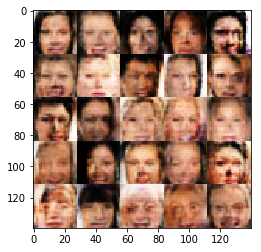

Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 0.9733
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 1.2526
Epoch 1/1... Discriminator Loss: 1.5784... Generator Loss: 0.5018
Epoch 1/1... Discriminator Loss: 1.5201... Generator Loss: 0.6700
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.8589
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.9495
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.8411
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.9127
Epoch 1/1... Discriminator Loss: 1.1890... Generator Loss: 0.8367


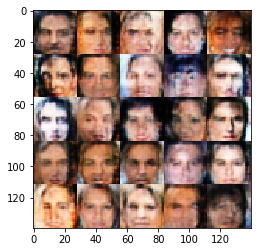

Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.0390... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.5237... Generator Loss: 0.5657
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.6148
Epoch 1/1... Discriminator Loss: 1.3937... Generator Loss: 1.3161
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 1.0036
Epoch 1/1... Discriminator Loss: 1.1321... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.5858
Epoch 1/1... Discriminator Loss: 1.2437... Generator Loss: 0.8789


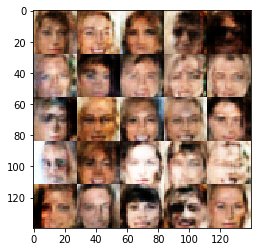

Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 0.8693
Epoch 1/1... Discriminator Loss: 1.0375... Generator Loss: 0.8932
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.5663
Epoch 1/1... Discriminator Loss: 1.1320... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 0.9408... Generator Loss: 1.3452
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.6133... Generator Loss: 1.1561
Epoch 1/1... Discriminator Loss: 1.1738... Generator Loss: 0.8383
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 1.0569


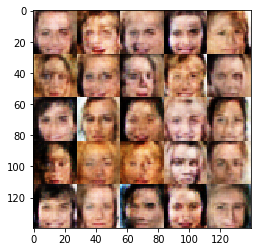

Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.5905
Epoch 1/1... Discriminator Loss: 1.1982... Generator Loss: 0.9411
Epoch 1/1... Discriminator Loss: 1.4700... Generator Loss: 1.3383
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 0.8406
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.6767
Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 1.3123
Epoch 1/1... Discriminator Loss: 0.9498... Generator Loss: 0.9479
Epoch 1/1... Discriminator Loss: 1.0898... Generator Loss: 0.8245
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.2202... Generator Loss: 1.0827


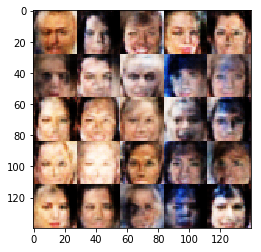

Epoch 1/1... Discriminator Loss: 1.1720... Generator Loss: 1.0543
Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 1.1767... Generator Loss: 1.1484
Epoch 1/1... Discriminator Loss: 1.6567... Generator Loss: 1.6045
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 0.8725
Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 1.0326
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 1.2014
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 1.2746... Generator Loss: 0.8627
Epoch 1/1... Discriminator Loss: 1.1543... Generator Loss: 1.0105


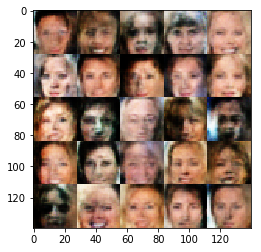

Epoch 1/1... Discriminator Loss: 0.9308... Generator Loss: 1.2924
Epoch 1/1... Discriminator Loss: 1.0297... Generator Loss: 1.0527
Epoch 1/1... Discriminator Loss: 1.1434... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.6719... Generator Loss: 1.7166
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.9818
Epoch 1/1... Discriminator Loss: 1.3744... Generator Loss: 1.3518
Epoch 1/1... Discriminator Loss: 1.1979... Generator Loss: 0.6820
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.5687
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 2.1787... Generator Loss: 0.3642


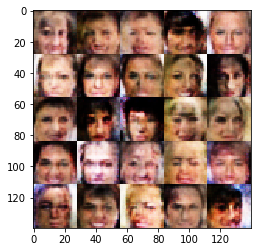

Epoch 1/1... Discriminator Loss: 1.3314... Generator Loss: 0.5940
Epoch 1/1... Discriminator Loss: 1.0254... Generator Loss: 0.9257
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 1.0171
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 0.8646... Generator Loss: 1.2968
Epoch 1/1... Discriminator Loss: 2.3419... Generator Loss: 0.3538
Epoch 1/1... Discriminator Loss: 1.5277... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.2285... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 1.2497
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.9717


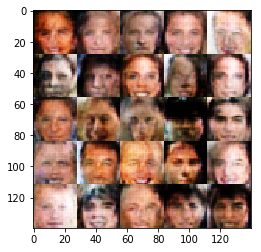

Epoch 1/1... Discriminator Loss: 1.1763... Generator Loss: 1.0495
Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 0.7361
Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 0.9345
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.5812
Epoch 1/1... Discriminator Loss: 0.9848... Generator Loss: 0.8513
Epoch 1/1... Discriminator Loss: 1.4293... Generator Loss: 0.5674
Epoch 1/1... Discriminator Loss: 1.5400... Generator Loss: 0.6229
Epoch 1/1... Discriminator Loss: 1.5216... Generator Loss: 1.3074
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.7093


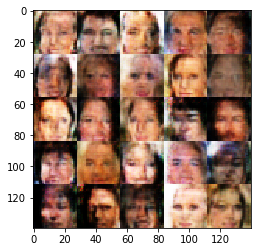

Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 1.0736
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 1.0383
Epoch 1/1... Discriminator Loss: 1.1502... Generator Loss: 0.9587
Epoch 1/1... Discriminator Loss: 1.1416... Generator Loss: 0.7962
Epoch 1/1... Discriminator Loss: 1.6893... Generator Loss: 0.4647
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 1.2157
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.9060
Epoch 1/1... Discriminator Loss: 1.3059... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.0584... Generator Loss: 0.9419


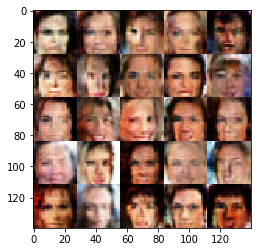

Epoch 1/1... Discriminator Loss: 1.4624... Generator Loss: 0.5466
Epoch 1/1... Discriminator Loss: 1.8596... Generator Loss: 0.4099
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.7491
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 1.1138
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 1.0148
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 1.3694
Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 1.0457
Epoch 1/1... Discriminator Loss: 1.4319... Generator Loss: 0.5422
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.8340


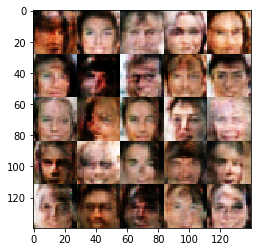

Epoch 1/1... Discriminator Loss: 0.9827... Generator Loss: 1.1682
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.7046
Epoch 1/1... Discriminator Loss: 1.0188... Generator Loss: 0.9223
Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 1.2014
Epoch 1/1... Discriminator Loss: 1.6772... Generator Loss: 0.4675
Epoch 1/1... Discriminator Loss: 1.6878... Generator Loss: 0.5437
Epoch 1/1... Discriminator Loss: 1.3347... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.7843


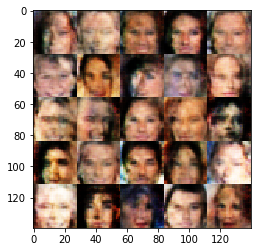

Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 1.2852
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.5660
Epoch 1/1... Discriminator Loss: 1.2662... Generator Loss: 1.0195
Epoch 1/1... Discriminator Loss: 1.1038... Generator Loss: 0.8675
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 1.1143
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 1.1969
Epoch 1/1... Discriminator Loss: 1.0903... Generator Loss: 1.4622
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 1.4863
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.6499


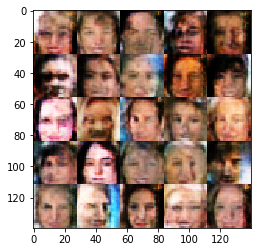

Epoch 1/1... Discriminator Loss: 0.9924... Generator Loss: 1.0769
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.7910... Generator Loss: 1.6774
Epoch 1/1... Discriminator Loss: 0.8442... Generator Loss: 1.1740
Epoch 1/1... Discriminator Loss: 1.4538... Generator Loss: 0.4995
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.5702... Generator Loss: 0.4632
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.6114
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 1.0898
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 0.8035


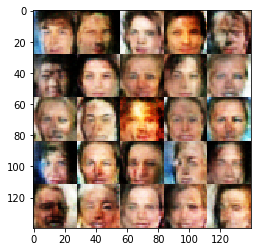

Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 1.0725
Epoch 1/1... Discriminator Loss: 0.7979... Generator Loss: 1.3704
Epoch 1/1... Discriminator Loss: 0.7649... Generator Loss: 1.2336
Epoch 1/1... Discriminator Loss: 0.6751... Generator Loss: 1.7372
Epoch 1/1... Discriminator Loss: 0.7743... Generator Loss: 1.8050
Epoch 1/1... Discriminator Loss: 1.0337... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 1.5837... Generator Loss: 0.4815
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 1.4596
Epoch 1/1... Discriminator Loss: 1.1899... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 0.9538... Generator Loss: 1.0973


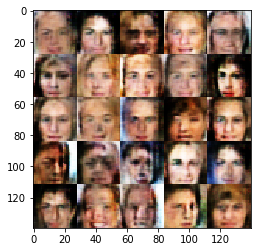

Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 1.6441
Epoch 1/1... Discriminator Loss: 0.7596... Generator Loss: 1.1191
Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 2.1617... Generator Loss: 2.6335
Epoch 1/1... Discriminator Loss: 0.9890... Generator Loss: 1.3744
Epoch 1/1... Discriminator Loss: 1.4513... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.8512
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.9383


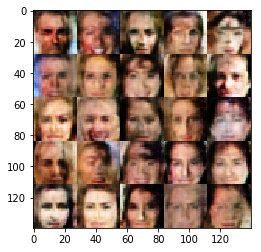

Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.8561
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.2985... Generator Loss: 0.7201
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 1.4851
Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.9249
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 0.9364
Epoch 1/1... Discriminator Loss: 1.0727... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 0.7491... Generator Loss: 1.3287


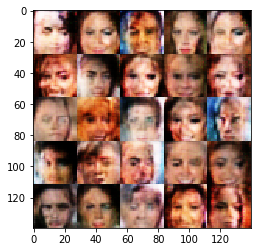

Epoch 1/1... Discriminator Loss: 0.7079... Generator Loss: 1.1376
Epoch 1/1... Discriminator Loss: 1.5376... Generator Loss: 1.0174
Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 0.9094
Epoch 1/1... Discriminator Loss: 1.2884... Generator Loss: 2.0370
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.2074... Generator Loss: 0.9630
Epoch 1/1... Discriminator Loss: 1.3045... Generator Loss: 1.3159
Epoch 1/1... Discriminator Loss: 0.8124... Generator Loss: 0.9966
Epoch 1/1... Discriminator Loss: 1.9455... Generator Loss: 2.8839
Epoch 1/1... Discriminator Loss: 1.2140... Generator Loss: 0.8334


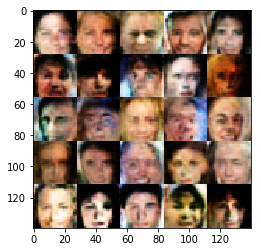

Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 0.8769
Epoch 1/1... Discriminator Loss: 1.1120... Generator Loss: 1.5763
Epoch 1/1... Discriminator Loss: 0.8586... Generator Loss: 1.2740
Epoch 1/1... Discriminator Loss: 1.7717... Generator Loss: 1.6753
Epoch 1/1... Discriminator Loss: 0.9465... Generator Loss: 0.9568
Epoch 1/1... Discriminator Loss: 1.5535... Generator Loss: 2.0491
Epoch 1/1... Discriminator Loss: 0.8445... Generator Loss: 1.4100
Epoch 1/1... Discriminator Loss: 0.9093... Generator Loss: 1.9625
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.6671
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 1.6205


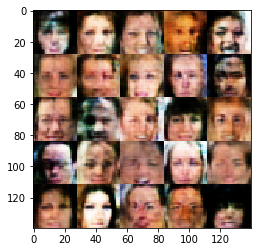

Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.7565
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 0.8322
Epoch 1/1... Discriminator Loss: 1.1486... Generator Loss: 1.5093
Epoch 1/1... Discriminator Loss: 0.9541... Generator Loss: 0.8073
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 1.4409
Epoch 1/1... Discriminator Loss: 0.6714... Generator Loss: 1.4148
Epoch 1/1... Discriminator Loss: 1.1287... Generator Loss: 1.3290
Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 0.8354
Epoch 1/1... Discriminator Loss: 1.6163... Generator Loss: 0.4885
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.8812


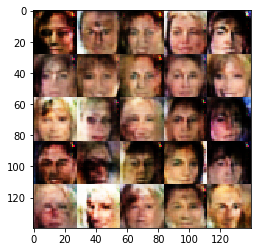

Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 1.7541
Epoch 1/1... Discriminator Loss: 1.1291... Generator Loss: 0.9668
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.0935... Generator Loss: 0.9245
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.5856
Epoch 1/1... Discriminator Loss: 1.3808... Generator Loss: 0.6027
Epoch 1/1... Discriminator Loss: 0.7619... Generator Loss: 1.3931
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 1.2350... Generator Loss: 0.5955
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 1.3307


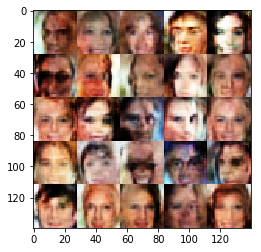

Epoch 1/1... Discriminator Loss: 0.8258... Generator Loss: 0.9606
Epoch 1/1... Discriminator Loss: 0.7535... Generator Loss: 1.3624
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.5164
Epoch 1/1... Discriminator Loss: 1.2567... Generator Loss: 0.8055
Epoch 1/1... Discriminator Loss: 1.1182... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.4882... Generator Loss: 0.5198
Epoch 1/1... Discriminator Loss: 1.2658... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.0323... Generator Loss: 1.4250
Epoch 1/1... Discriminator Loss: 1.0737... Generator Loss: 0.7360
Epoch 1/1... Discriminator Loss: 1.8905... Generator Loss: 0.3981


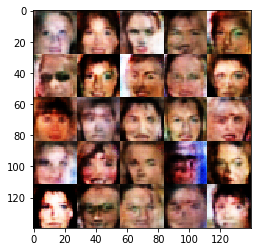

Epoch 1/1... Discriminator Loss: 1.1714... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.0216... Generator Loss: 0.8898
Epoch 1/1... Discriminator Loss: 0.9737... Generator Loss: 0.9121
Epoch 1/1... Discriminator Loss: 0.9132... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 0.8884... Generator Loss: 1.0267
Epoch 1/1... Discriminator Loss: 2.2915... Generator Loss: 0.3591
Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 0.9262... Generator Loss: 1.3263
Epoch 1/1... Discriminator Loss: 1.1504... Generator Loss: 1.4641
Epoch 1/1... Discriminator Loss: 0.5188... Generator Loss: 1.7837


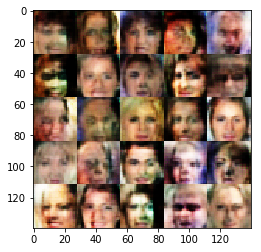

Epoch 1/1... Discriminator Loss: 1.0550... Generator Loss: 1.2327
Epoch 1/1... Discriminator Loss: 0.5821... Generator Loss: 1.5617
Epoch 1/1... Discriminator Loss: 0.7735... Generator Loss: 1.7382
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.9917


In [ ]:
batch_size = 64 # 128
z_dim = 100
learning_rate = 0.001 # 0.0002
beta1 = 0.3 # 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.